In [11]:
from typing import List
import os

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from time import time
from joblib import Parallel, delayed

from src.QAOA.Qiskit_QAOA import Qiskit_QAOA
#from src.QAOA.Qsim_CP_VQA import Qsim_QAOA
from src.QAOA.Qulacs_QAOA import Qulacs_QAOA

from src.Qubo import Qubo
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       check_qubo)

In [2]:
def simulate(settings_list: List[dict]) -> List[dict]:
    final_result = []
    for settings in settings_list:
        result = {'N':settings['N']}
        # Generating random problem instance 
        expected_returns, covariances = portfolio_metrics(n=settings['N'], seed=settings['seed'])
        # Retrieving C_min, C_max and corresponding states for original portfolio problem
        constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=settings['N'],
                                                                    k=settings['k'],
                                                                    mu=expected_returns,
                                                                    sigma=covariances,
                                                                    alpha=settings['alpha'])
    
        # Generating QUBO corresponding to current problem instance
        Q, offset = get_qubo(mu=expected_returns,
                             sigma=covariances, 
                             alpha=settings['alpha'],
                             lmbda=lmbda+1, # Adding small constant purposely
                             k=settings['k'])
        qubo = Qubo(Q=Q, offset=offset) 
        qubo.subspace_c_min, qubo.subspace_c_max = constrained_result['c_min'], constrained_result['c_max']
        qubo.subspace_x_min, qubo.subspace_x_max = constrained_result['s_min'], constrained_result['s_max']
        qubo.full_space_c_min, qubo.full_space_c_max = full_result['c_min'], full_result['c_max']
        check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=settings['alpha'], k=settings['k'])
         
        
        """qsim = Qsim_QAOA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           qubo=qubo)"""
        
        qulacs = Qulacs_QAOA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           qubo=qubo)
         
        qiskit = Qiskit_QAOA(N_qubits=settings['N'],
                           cardinality=settings['k'],
                           layers=settings['L'],
                           qubo=qubo)
         
        
         # Generating initial guess for rotation angles
        np.random.seed(settings['seed'])
        theta_min, theta_max = -2*np.pi, 2*np.pi
        QAOA_theta_i = np.random.uniform(theta_min, theta_max, 2*settings['L'])
        
        qiskit_start_time = time()
        qiskit_sim = sc.optimize.minimize(fun=qiskit.get_cost, 
                                  x0=QAOA_theta_i,
                                  method=settings['opt_method'],
                                  options={'disp': False, 
                                           'maxiter': settings['max_iter']})
        qiskit_stop_time = time()
        if qiskit_sim['nfev'] > 0:
            time_pr_iter = (qiskit_stop_time-qiskit_start_time) / qiskit_sim['nfev']
            result['qiskit'] = time_pr_iter
        
    
        """qsim_start_time = time()
        qsim_sim = sc.optimize.minimize(fun=qsim.get_cost, 
                                  x0=QAOA_theta_i,
                                  method=settings['opt_method'],
                                  options={'disp': False, 
                                           'maxiter': settings['max_iter']})
        qsim_stop_time = time()
        if qsim_sim['nfev'] > 0:
            time_pr_iter = (qsim_stop_time-qsim_start_time) / qsim_sim['nfev']
            result['qsim'] = time_pr_iter"""
             
        
        qulacs_start_time = time()
        qulacs_sim = sc.optimize.minimize(fun=qulacs.get_cost, 
                                  x0=QAOA_theta_i,
                                  method=settings['opt_method'],
                                  options={'disp': False, 
                                           'maxiter': settings['max_iter']})
        qulacs_stop_time = time()
        if qulacs_sim['nfev'] > 0:
            time_pr_iter = (qulacs_stop_time-qulacs_start_time) / qulacs_sim['nfev']
            result['qulacs'] = time_pr_iter
            
        final_result.append(result)
        
    return  final_result

In [13]:
layer_dict = {2:4,  3:4,  4:4,
              5:4,  6:4,  7:4,
              8:4,  9:4,  10:4,
              11:4, 12:4, 13:4,
              14:4, 15:4, 16:4,
              17:4, 18:4, 19:4, 
              20:4}

max_iter = 4
alpha=0.5
N_seeds = 8
N_min, N_max = 2, 20
sim_settings = []
for seed in range(N_seeds):
    chunck = []
    for N in range(N_min, N_max+1):
        topology = Chain(N_qubits=N)
        topology.set_initialization_strategy(strategy=np.array([0 if i%2 == 0 else 1 for i in range(N)]))
        setting = {'N'         :N,       'alpha'   :alpha,   'L'       :layer_dict[N], 
                   'seed'      :seed,    'topology':topology,'max_iter':max_iter,
                   'opt_method':'COBYLA','w_nnn'   :True,    'k'       :N//2}
        chunck.append(setting)
    sim_settings.append(chunck)

In [14]:
N_jobs=os.cpu_count()
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(setting) for setting in sim_settings)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [6]:
qiskit_res  = {N: [] for N in range(N_min,N_max+1)}
qulacs_res  = {N: [] for N in range(N_min,N_max+1)}
qsim_res    = {N: [] for N in range(N_min,N_max+1)}

for l in r:
    for res in l: 
        if res['qiskit'] is not None:
            qiskit_res[res['N']].append(res['qiskit'])
        if res['qulacs'] is not None:
            qulacs_res[res['N']].append(res['qulacs'])
        """if res['qsim'] is not None:
            qsim_res[res['N']].append(res['qsim'])"""
        

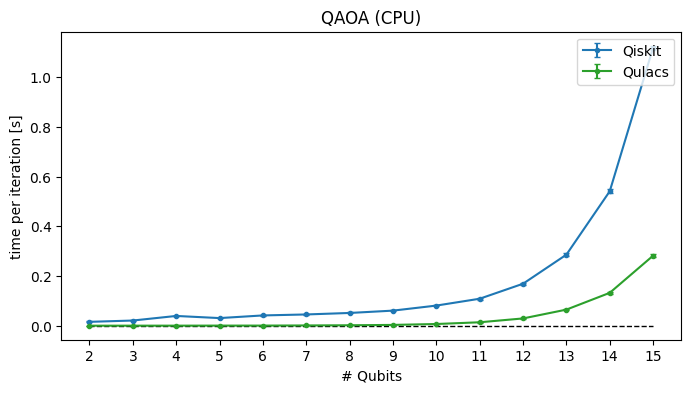

In [10]:
qiskit_avgs = np.array([[np.mean(qiskit_res[key]), np.std(qiskit_res[key])] for key in qiskit_res.keys()])
#qsim_avgs = np.array([[np.mean(qsim_res[key]), np.std(qsim_res[key])] for key in qsim_res.keys()])
qulacs_avgs = np.array([[np.mean(qulacs_res[key]), np.std(qulacs_res[key])] for key in qulacs_res.keys()])

N_vals = [n for n in range(N_min, N_max+1)]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.set_title('QAOA (CPU)')

ax.errorbar(N_vals, qiskit_avgs[:,0], yerr=qiskit_avgs[:,1], fmt='.-', capsize=2, label='Qiskit', color='tab:blue')
#ax.errorbar(N_vals, qsim_avgs[:,0], yerr=qsim_avgs[:,1], fmt='.-', capsize=2, label='Qsim', color='tab:red')
ax.errorbar(N_vals, qulacs_avgs[:,0], yerr=qulacs_avgs[:,1], fmt='.-', capsize=2, label='Qulacs', color='tab:green')

ax.hlines(0, N_vals[0], N_vals[-1],ls='--',color='k', lw = 1)
ax.set_ylabel('time per iteration [s]')
ax.set_xlabel('# Qubits')
ax.set_xticks(N_vals)




ax.legend(loc='upper right')
#plt.savefig('simulator_comparison_3.png', dpi=400)